### Yandex Metrika API - user activity

In [4]:
import pandas as pd

import requests
from urllib.parse import urlencode
import json

import seaborn as sns
import matplotlib.pyplot as plt

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

import vk_api

import random

from io import BytesIO

In [42]:
# get sample data from yandex api metrika 
url = 'https://api-metrika.yandex.net/stat/v1/data?'
dates = ['2021-07-16', '2021-07-17', '2021-07-18']
df = pd.DataFrame()

for date in dates:
    #create links to take desired data from 
    params = {'dimensions' :['ym:s:date', 'ym:s:isRobot', 'ym:s:browser'],
              'metrics'    :'ym:s:visits',
              'filters'    :f"ym:s:date=='{date}'",
              'id'         :44147844}   

    visits = urlencode(params, doseq=True, )
    visits_url = url + visits
    
    response = requests.get(visits_url)
    #save data as json
    json_data = response.json()
    
    #extract data   
    for record in json_data['data']:

        intermediate_data = record['dimensions']

        visits = record['metrics'][0]
        date = intermediate_data[0]['name']
        robot_type = intermediate_data[1]['name']
        browser = intermediate_data[2]['name']

        row = [[date, robot_type, visits, browser]]
        #add data to df
        df = df.append(row)
        
df.columns=['date', 'type', 'visits', 'browser']

In [43]:
df.head()

,date,type,visits,browser
0,2021-07-16,People,157.0,Google Chrome
0,2021-07-16,Robots,109.0,Google Chrome
0,2021-07-16,People,34.0,Yandex Browser
0,2021-07-16,People,33.0,Chrome Mobile
0,2021-07-16,People,16.0,Firefox


First, let's look at the distribution of site visits by day. (by bots and real users)

<AxesSubplot:xlabel='date', ylabel='visits'>

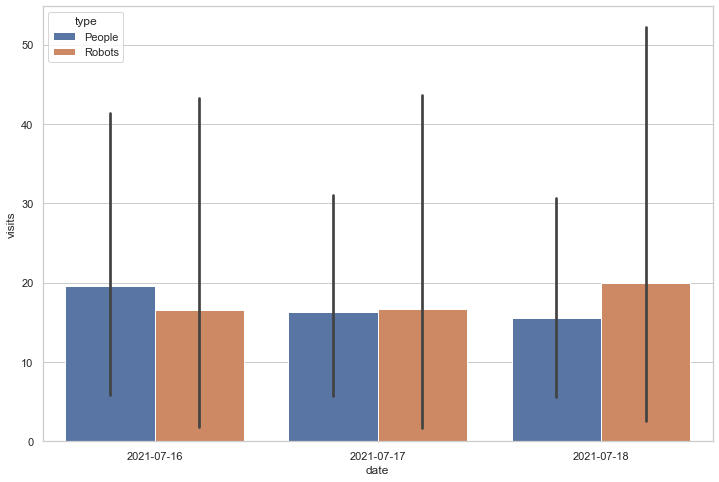

In [44]:
# set the graph
sns.set(style='whitegrid',
        rc={'figure.figsize':(12, 8)})

# Build a graph showing the distribution of the # of visits from bots and regular users

sns.barplot(data=df,
            x='date',
            y='visits',
            hue='type')

In [60]:
# What is the share of Google Chrome visits?

In [61]:
# total visists from Google Chrome

chrome_visits = df.query('browser == "Google Chrome"').visits.sum()

In [62]:
# total visists from all browsers

all_visits = df.visits.sum()

In [63]:
# share of Google Chrome visits (%)

chrome_visits_share = chrome_visits / all_visits * 100
chrome_visits_share.round()

60.0

In [46]:
# What browser shows the most of bots visits?

In [64]:
# total visits by browser

visits_browser = df.groupby('browser', as_index=False) \
                    .agg({'visits':'sum'})

In [65]:
visits_browser

,browser,visits
0,Android Browser,17.0
1,Chrome Mobile,97.0
2,Edge,32.0
3,Firefox,60.0
4,Firefox Mobile,1.0
5,Google Chrome,616.0
6,Huawei Browser,1.0
7,MIUI,8.0
8,MSIE,1.0
9,Mobile Safari,39.0


In [66]:
# merge df and new dataframe called full_df. Adding a column with total visits by browser

full_df = df.merge(visits_browser,
                   on='browser',
                   suffixes=('_type', '_all'))

In [67]:
# add new column: ratio of visits by people/bots to total visists for each browser  

full_df['ratio_by_browser'] = full_df.visits_type / full_df.visits_all

In [68]:
full_df.head()

,date,type,visits_type,browser,visits_all,ratio_by_browser
0,2021-07-16,People,157.0,Google Chrome,616.0,0.254870
1,2021-07-16,Robots,109.0,Google Chrome,616.0,0.176948
2,2021-07-17,People,89.0,Google Chrome,616.0,0.144481
3,2021-07-17,Robots,82.0,Google Chrome,616.0,0.133117
4,2021-07-18,People,94.0,Google Chrome,616.0,0.152597


In [69]:
# what browser has the largets share of visits by bots ?

full_df.query('type == "Robots"') \
        .nlargest(1, 'ratio_by_browser')

,date,type,visits_type,browser,visits_all,ratio_by_browser
57,2021-07-16,Robots,1.0,Firefox Mobile,1.0,1.0


In [53]:
# Let's find the share of robots/ people visits from each browser from all visists for each day

In [70]:
# adding column with the share of visits by user type

full_df['ratio_type_to_all_visits'] = round(
                                            full_df.visits_type / all_visits * 100,
                                                1)

In [71]:
# reorganize data 

ratio_by_date_browser_user = full_df.pivot(
                                            index=['date', 'browser'],
                                            columns='type',
                                            values='ratio_type_to_all_visits')

In [72]:
ratio_by_date_browser_user

type                           People  Robots
date       browser                           
2021-07-16 Android Browser        0.8     NaN
           Chrome Mobile          3.2     NaN
           Edge                   0.7     0.4
           Firefox                1.6     1.1
           Firefox Mobile         NaN     0.1
           Google Chrome         15.3    10.7
           Huawei Browser         0.1     NaN
           MIUI                   0.1     0.1
           Mobile Safari          1.4     NaN
           Opera                  0.3     0.1
           Opera Mini             0.1     NaN
           Safari                 1.1     0.2
           Samsung Internet       0.3     NaN
           UCWEB                  0.3     NaN
           Yandex Browser         3.3     0.3
           Yandex: mobile app     0.2     NaN
2021-07-17 Android Browser        0.3     NaN
           Chrome Mobile          3.6     NaN
           Edge                   0.3     0.5
           Firefox                1.0     1.0
           Google Chrome          8.7     8.0
           MIUI                   0.3     0.1
           MSIE                   0.1     NaN
           Mobile Safari          1.7     0.1
           Opera                  0.5     NaN
           Safari                 0.8     0.1
           Samsung Internet       0.3     NaN
           Yandex Browser         1.6     NaN
2021-07-18 Android Browser        0.6     NaN
           Chrome Mobile          2.6     NaN
           Edge                   1.0     0.3
           Firefox                0.6     0.7
           Google Chrome          9.2     8.3
           MIUI                   0.2     NaN
           Mobile Safari          0.7     NaN
           Opera                  0.3     0.2
           Safari                 0.7     0.3
           Samsung Internet       0.5     NaN
           UCWEB                  0.3     NaN
           Yandex Browser         2.8     NaN
           Yandex: mobile app     0.3     NaN

In [ ]:
# Sending data to Google SpreadSheet and messaging a link to it via vk API

In [220]:
# read file with vk user id, email & token for vk api
with open('/Users/viktorial/Karpov/Data/Data_for_python/7pythonAPIYandexMetrika.rtf', 'r') as file:
    text = file.readlines()

# open json file with google api key
path_to_credentials = '/Users/viktorial/Downloads/tidal-repeater-318610-7d2bb1579f3a.json'

# email with access to Google SpreadSheet
my_mail = text[-4][:-2]

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# authorize
credentials = ServiceAccountCredentials.from_json_keyfile_name(path_to_credentials, scope)
gs = gspread.authorize(credentials)

In [233]:
# create empty SpreadSheet
table_name = 'ratio by date, by browser, by user type'
sheet_s = gs.create(table_name)

# open SpreadSheet
work_sheet = gs.open(table_name)

#grant access to SpreadSheet 
work_sheet.share(my_mail, perm_type='user', role='writer')

# export ratio_by_date_browser_user df to SpreadSheet
sheet = 'Master'

d2g.upload(full_df,
           table_name,
           sheet,
           credentials=credentials,
           row_names=True)

<Worksheet 'Master' id:1378552913>

In [234]:
# link to SpreadSheet with df
spreadsheet_url = "https://docs.google.com/spreadsheets/d/%s" % sheet_s.id
spreadsheet_url

'https://docs.google.com/spreadsheets/d/1G0vXQxJgUjokwGvesg4VLrPchxkEMAJhunTbSZ_HAB0'

In [229]:
# token
token_vk = text[-3][:-2]

# vk user id
my_id = text[-1][:-1]

# Initialize session
vk_session = vk_api.VkApi(token=token_vk)

# Make it possible to use vk api methods as python methods
vk = vk_session.get_api()

In [230]:
# sending the message via vk 
vk.messages.send(
                user_id=my_id,
                random_id=random.randint(1, 2 ** 31),  # random number for message identification
                message=spreadsheet_url)

16